In [69]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
import cartopy.crs as ccrs
import gsw
from eofs.xarray import Eof
from scipy.fft import fft, fftfreq
import pandas as pd
from sklearn.linear_model import LinearRegression
import importlib
from matplotlib.lines import Line2D



import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


from utils import *
import utils_variability
import scipy.stats

# Data processing



## Loading data

In [70]:
ds_surface = load_surface_data()
print(f'Size of the dataset: {ds_surface.nbytes/1e9} GB')

Size of the dataset: 1.229445704 GB


In [71]:
ds_atm = load_atm_data()
print(f'Size of the dataset: {ds_atm.nbytes/1e9} GB')

Size of the dataset: 2.810157224 GB


In [72]:
ds = xr.merge([ds_surface, ds_atm])
print(f'Size of the dataset: {ds.nbytes/1e9} GB')

Size of the dataset: 4.039588424 GB


In [73]:
ds_winter = ds.where(ds.time.dt.month == 3, drop=True)
ds_summer = ds.where(ds.time.dt.month == 9, drop=True)

del ds, ds_surface, ds_atm

In [74]:
variables_to_keep = [
    'T', 'sst', 't2m', 'msl', 'sd', 'SIT', 'SIC', 'u10', 'v10', 'U', 'V'
]

ds_winter = ds_winter[variables_to_keep].load()
ds_summer = ds_summer[variables_to_keep].load()
print(f'Size of the dataset: {ds_winter.nbytes/1e9} GB')

Size of the dataset: 0.161004176 GB


In [75]:
ds_climate_index = get_climate_index()

ds_winter_climate_index = ds_climate_index.sel(time=ds_winter.time)
ds_summer_climate_index = ds_climate_index.sel(time=ds_summer.time)

/Users/juliencollard/Nextcloud/Documents/Travail/Sorbonne/Cours/Code_MOCIS/PHO/PHO_Arctic/utils.py:200: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f'data/{name}.csv', delim_whitespace=True, skiprows=0, names=['Year', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
/Users/juliencollard/Nextcloud/Documents/Travail/Sorbonne/Cours/Code_MOCIS/PHO/PHO_Arctic/utils.py:200: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f'data/{name}.csv', delim_whitespace=True, skiprows=0, names=['Year', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
/Users/juliencollard/Nextcloud/Documents/Travail/Sorbonne/Cours/Code_MOCIS/PHO/PHO_Arctic/utils.py:200: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df

## Computing anomalies

In [76]:
# Compute climatology
ds_winter_climatology = ds_winter.mean('time')
ds_summer_climatology = ds_summer.mean('time')

# Compute anomalies
ds_winter_anomalies = ds_winter - ds_winter_climatology
ds_summer_anomalies = ds_summer - ds_summer_climatology

for var in ds_winter_anomalies.data_vars:
    ds_winter_anomalies[var].attrs = ds_winter[var].attrs

for var in ds_summer_anomalies.data_vars:
    ds_summer_anomalies[var].attrs = ds_summer[var].attrs

## Detrending anomalies

In [44]:
# Compute anomalies trends

trends_coefs = ds_winter_anomalies.polyfit('time', 2)
ds_winter_trends = xr.polyval(ds_winter_anomalies.time, trends_coefs)
ds_winter_trends = ds_winter_trends.rename_vars({f'{var}_polyfit_coefficients': f'{var}' for var in ds_winter_anomalies.data_vars})

trends_coefs = ds_summer_anomalies.polyfit('time', 2)
ds_summer_trends = xr.polyval(ds_summer_anomalies.time, trends_coefs)
ds_summer_trends = ds_summer_trends.rename_vars({f'{var}_polyfit_coefficients': f'{var}' for var in ds_summer_anomalies.data_vars})

### Trends analysis

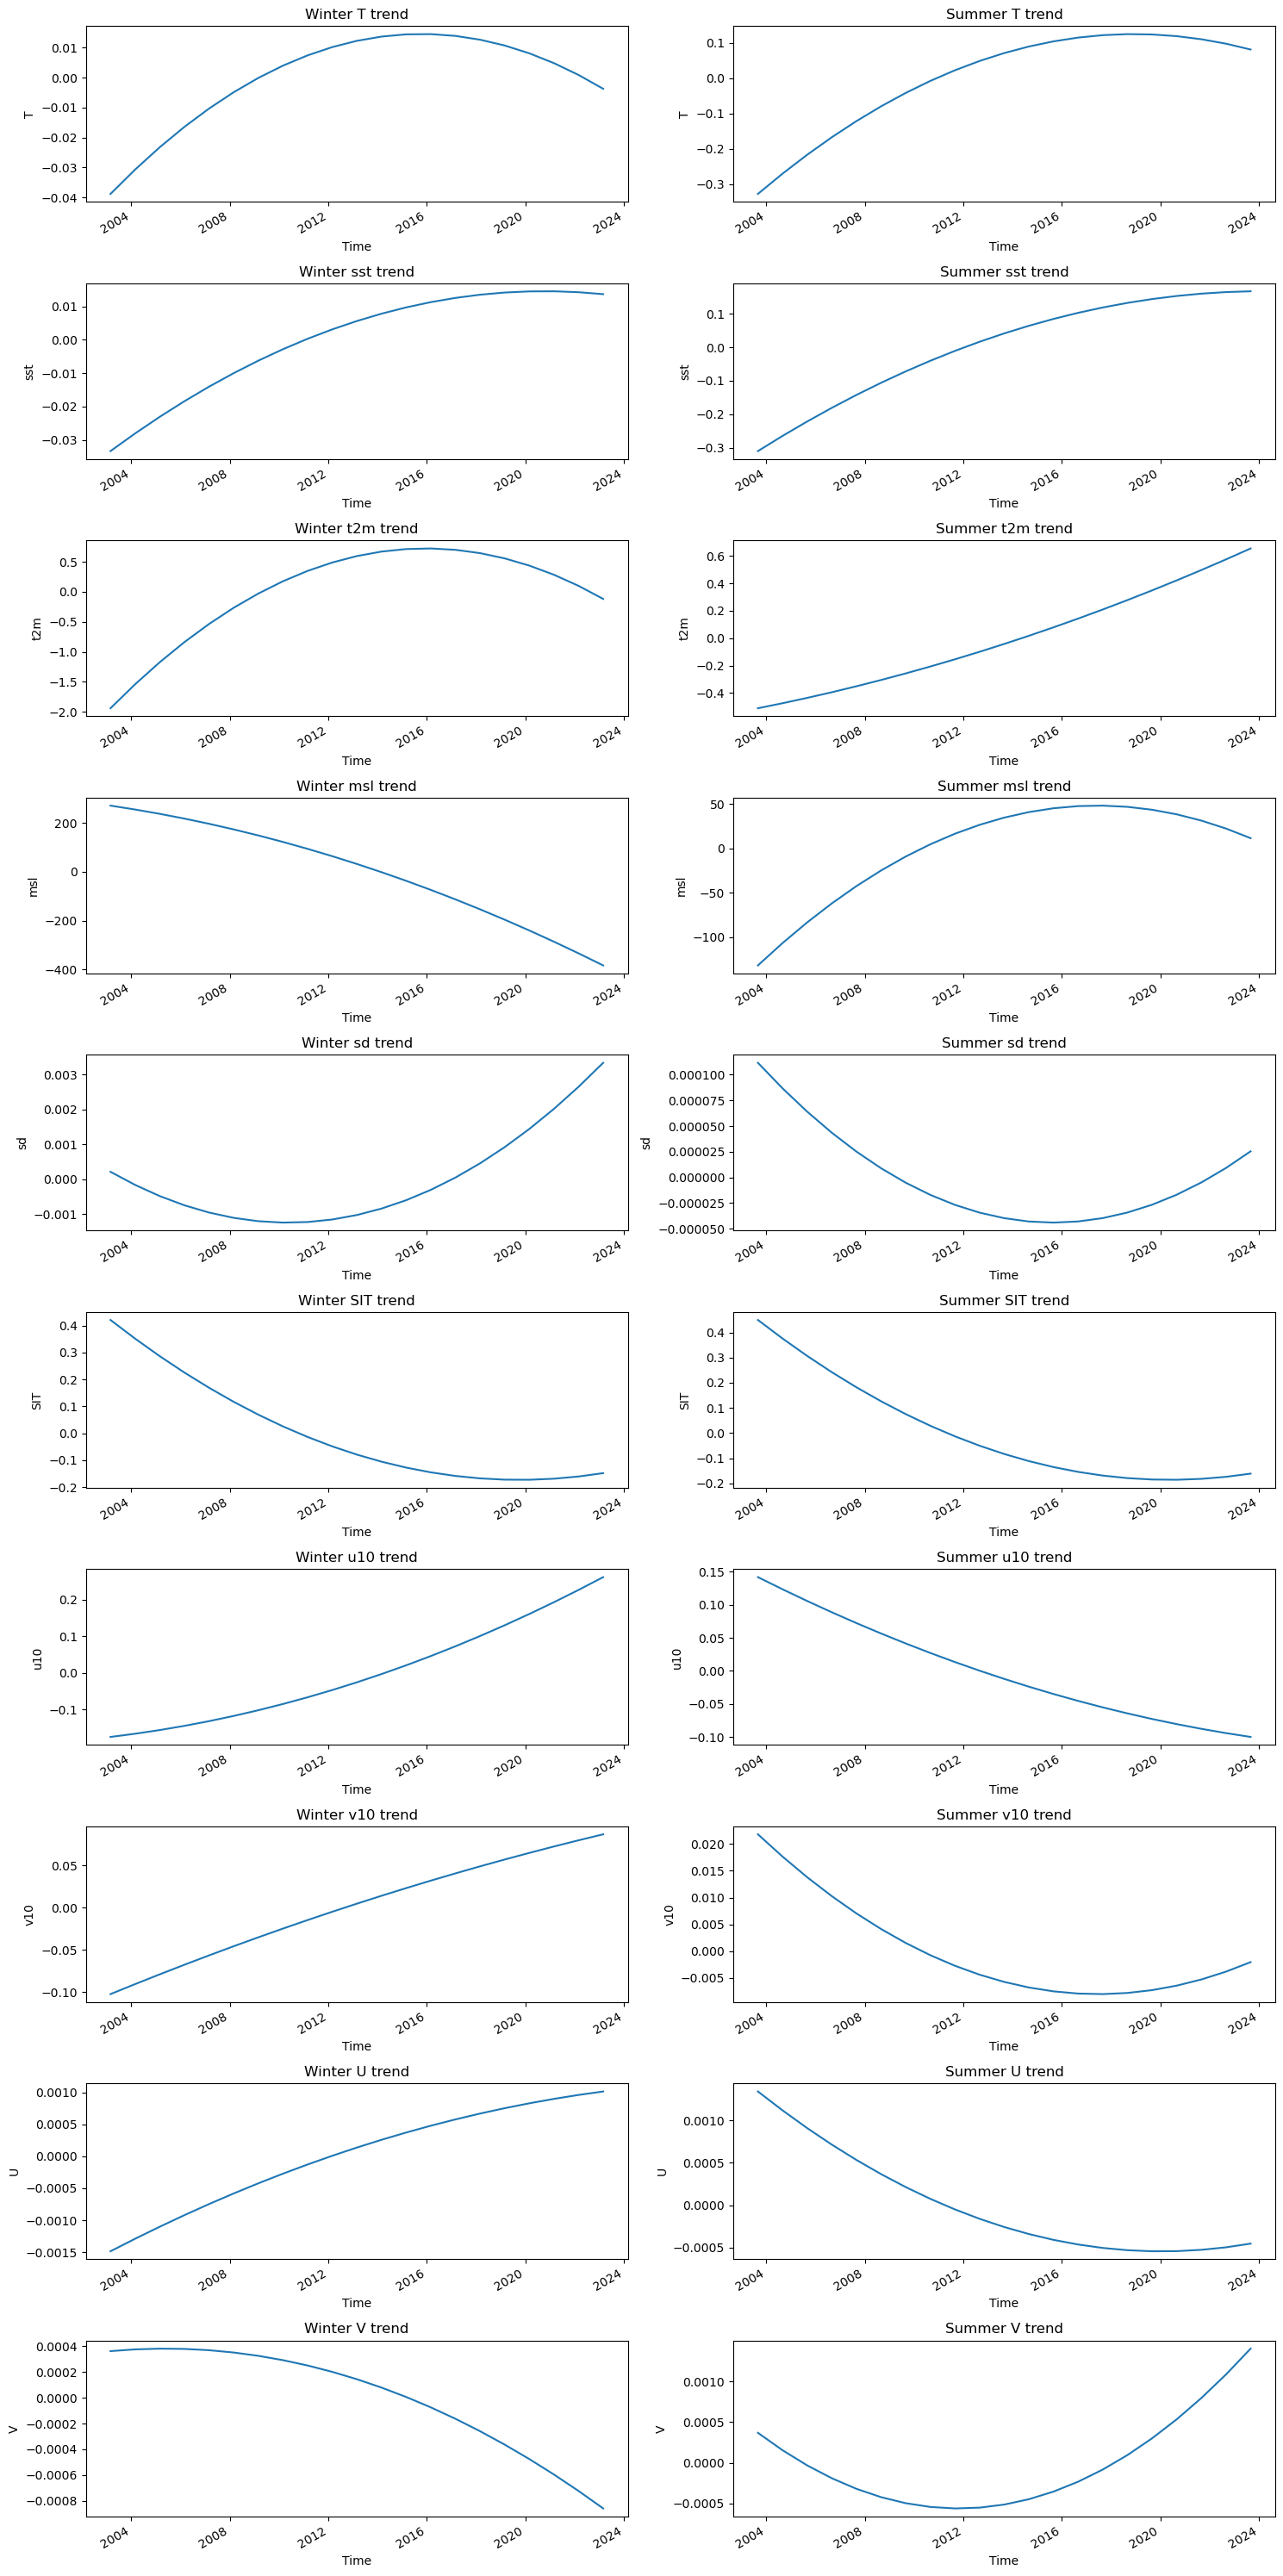

In [45]:
fig, axs = plt.subplots(len(ds_winter_trends.data_vars), 2, figsize=(15, 3*len(ds_winter_trends.data_vars)))

for i, var in enumerate(ds_winter_trends.data_vars):
    ds_winter_trends[var].mean(['latitude', 'longitude']).plot(ax=axs[i, 0])
    ds_summer_trends[var].mean(['latitude', 'longitude']).plot(ax=axs[i, 1])
    axs[i, 0].set_title(f'Winter {var} trend')
    axs[i, 1].set_title(f'Summer {var} trend')

plt.tight_layout()
plt.show()


In [46]:
# Remove trends
ds_winter_anomalies_detrended = ds_winter_anomalies - ds_winter_trends
ds_summer_anomalies_detrended = ds_summer_anomalies - ds_summer_trends

for var in ds_winter_anomalies_detrended.data_vars:
    ds_winter_anomalies_detrended[var].attrs = ds_winter[var].attrs

for var in ds_summer_anomalies_detrended.data_vars:
    ds_summer_anomalies_detrended[var].attrs = ds_summer[var].attrs

# Variabiliy analysis

In [47]:
importlib.reload(utils_variability)

<module 'utils_variability' from '/Users/juliencollard/Nextcloud/Documents/Travail/Sorbonne/Cours/Code_MOCIS/PHO/PHO_Arctic/utils_variability.py'>

## Winter

### SLP EOFs

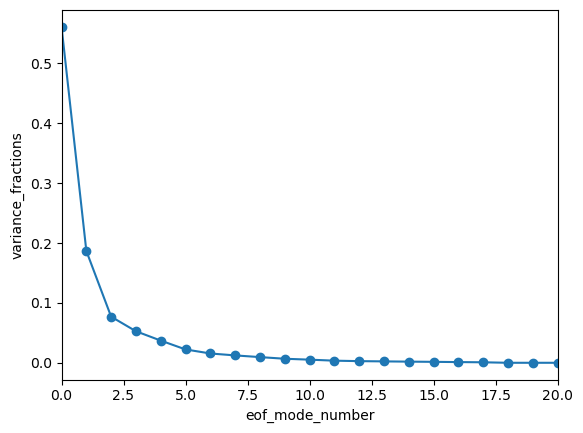

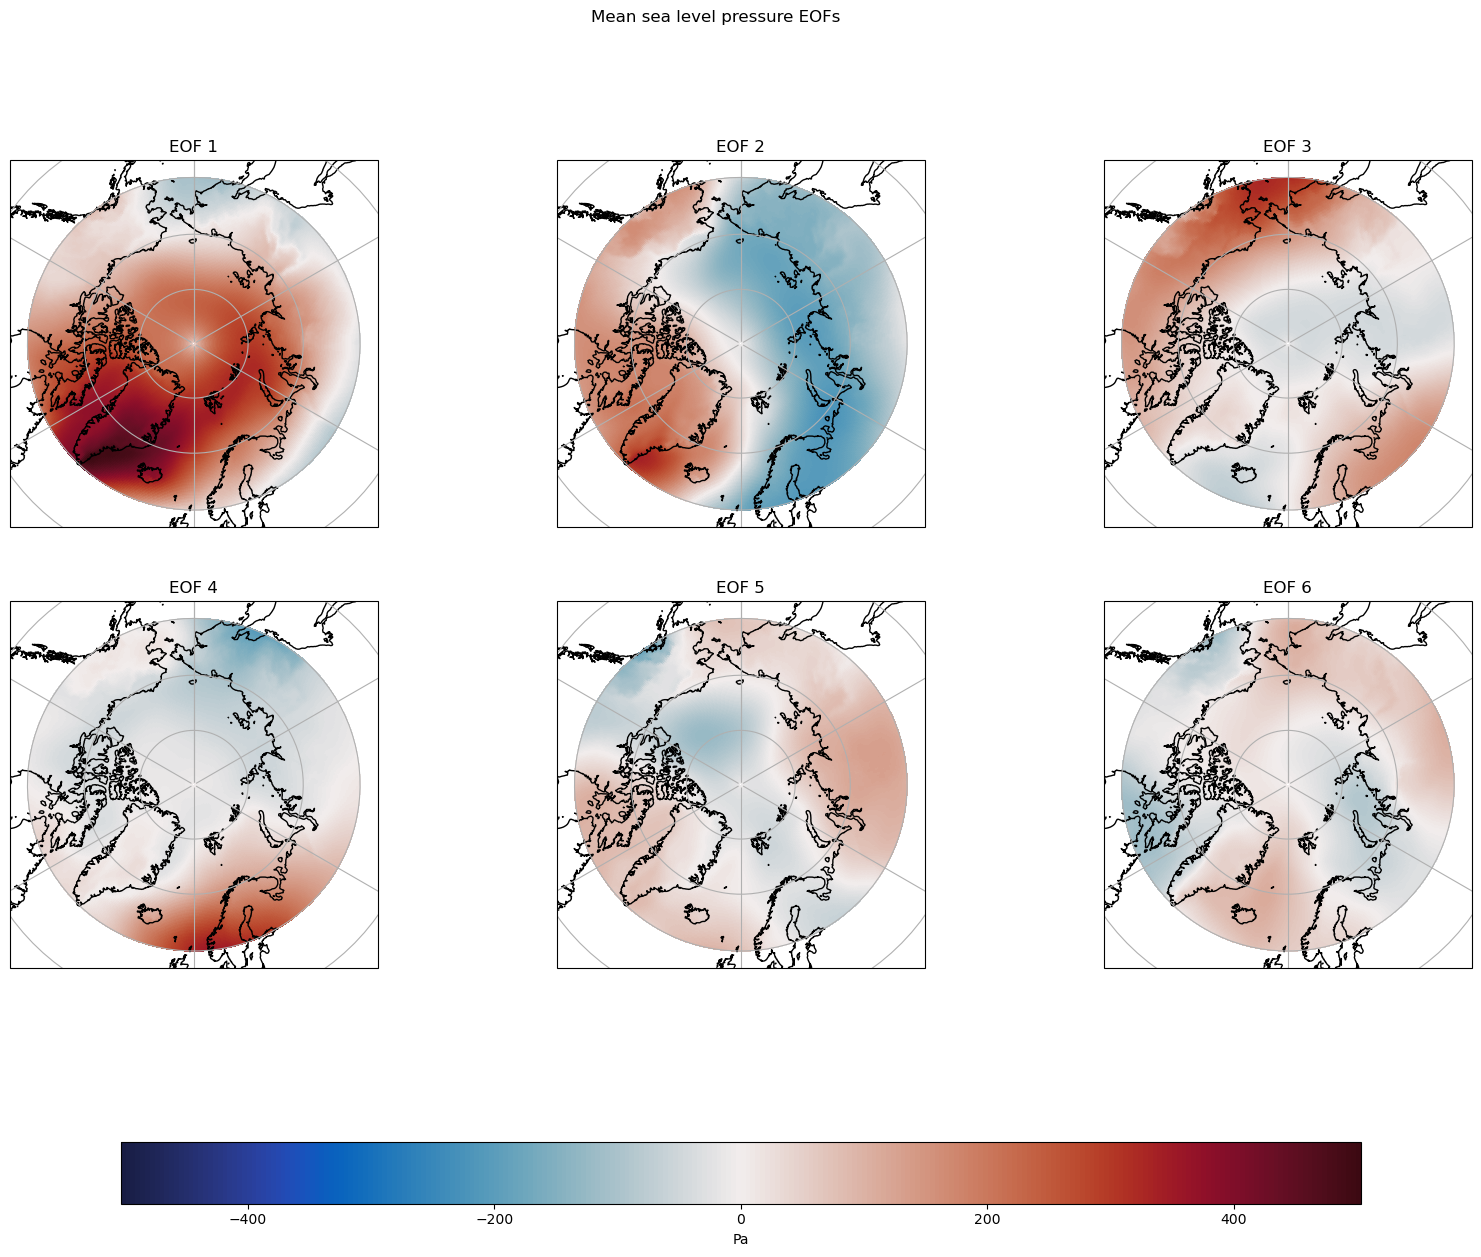

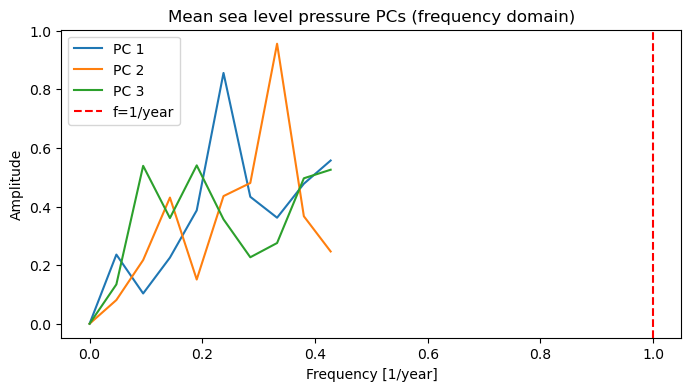

In [50]:
# Computing EOFs
da = ds_winter_anomalies_detrended['msl']
winter_msl_eof_solver = utils_variability.fit_eofs(da)
utils_variability.fast_eof_analysis(winter_msl_eof_solver, da)

#### AO ?

In [51]:
measured_AO = ds_winter_climate_index['AO']
pc1 = winter_msl_eof_solver.pcs(1)[:,0]

corr = np.corrcoef(measured_AO, pc1)[0,1]
print(f'Correlation between measured and predicted AO: {corr}')

AO_time_serie_from_PC1 = pc1 * corr
AO_EOF_from_EOF1 = winter_msl_eof_solver.eofs(eofscaling=2)[0] * corr

Correlation between measured and predicted AO: -0.8841072158390821


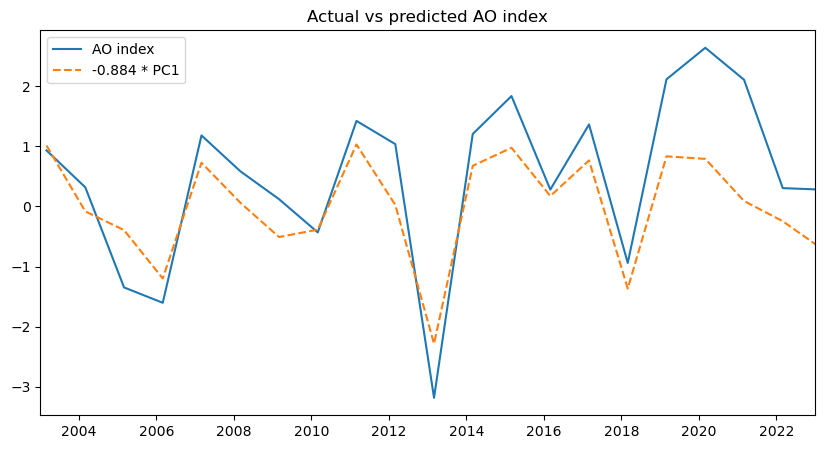

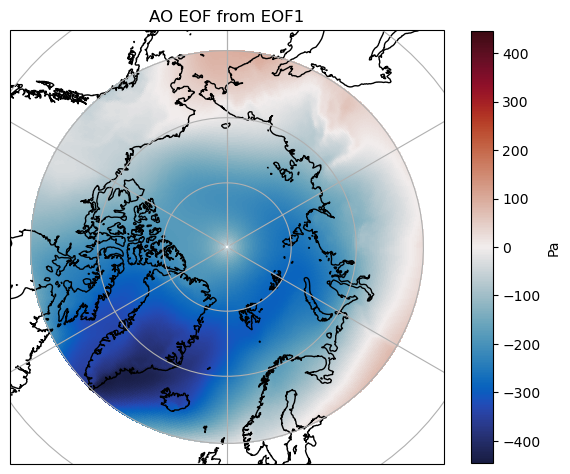

In [52]:
plt.figure(figsize=(10, 5))
plt.plot(ds_winter_climate_index.time,measured_AO, label='AO index')
plt.plot(winter_msl_eof_solver.pcs(1).time, AO_time_serie_from_PC1, label=f'{corr:.3f} * PC1', linestyle='--')
plt.legend()
plt.title('Actual vs predicted AO index')
plt.xlim(pd.DatetimeIndex(['2003-01-01', '2023-01-01']))
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(AO_EOF_from_EOF1).max()
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    AO_EOF_from_EOF1.longitude, 
    AO_EOF_from_EOF1.latitude, 
    AO_EOF_from_EOF1, 
    transform=ccrs.PlateCarree(), 
    cmap=cmo.balance,
    norm=colors.Normalize(vmin=-max_val, vmax=max_val),
)
ax.set_title(f'AO EOF from EOF1')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label=da.units)
plt.show()

### Regressions on AO EOF

In [53]:
projection = (ds_winter_anomalies_detrended * AO_time_serie_from_PC1).mean('time')
projection

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 1440)
Coordinates:
    depth      float32 0.5058
  * latitude   (latitude) float32 60.0 60.25 60.5 60.75 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    mode       int64 0
Data variables:
    T          (latitude, longitude) float64 0.2705 0.3088 ... -0.002632
    sst        (latitude, longitude) float64 0.2505 0.2581 ... 7.717e-06
    t2m        (latitude, longitude) float64 0.4074 0.4066 ... 0.2774 0.2774
    msl        (latitude, longitude) float64 124.5 124.0 123.4 ... -710.5 -710.5
    sd         (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SIT        (latitude, longitude) float64 -0.002632 -0.004819 ... 0.02953
    u10        (latitude, longitude) float64 -0.188 -0.1813 ... 0.1624 0.1624
    v10        (latitude, longitude) float64 -0.1057 -0.1023 ... -0.002324
    U          (latitude, longitude) float64 0.009908 0.008524 ... 0.0002253
    V          (latitude, longitude) float64 0.0008053 0.001986 ... -2.317e-05

In [62]:
wind_ampl = np.sqrt(projection['u10']**2 + projection['v10']**2)
u_norm = projection['u10']
v_norm = projection['v10'] * np.cos(np.deg2rad(projection.latitude))

u_norm = u_norm / np.sqrt(u_norm**2 + v_norm**2)
v_norm = v_norm / np.sqrt(u_norm**2 + v_norm**2)

projection['u10_plot'] = u_norm * wind_ampl
projection['v10_plot'] = v_norm * wind_ampl

current_ampl = np.sqrt(projection['U']**2 + projection['V']**2)
u_norm = projection['U']
v_norm = projection['V'] * np.cos(np.deg2rad(projection.latitude))

u_norm = u_norm / np.sqrt(u_norm**2 + v_norm**2)
v_norm = v_norm / np.sqrt(u_norm**2 + v_norm**2)

projection['U_plot'] = u_norm * current_ampl
projection['V_plot'] = v_norm * current_ampl

longitude_mg ,latitude_mg = np.meshgrid(projection.longitude, projection.latitude)

sea_mask = ~ projection['sst'].isnull()

##### Atmospheric climate

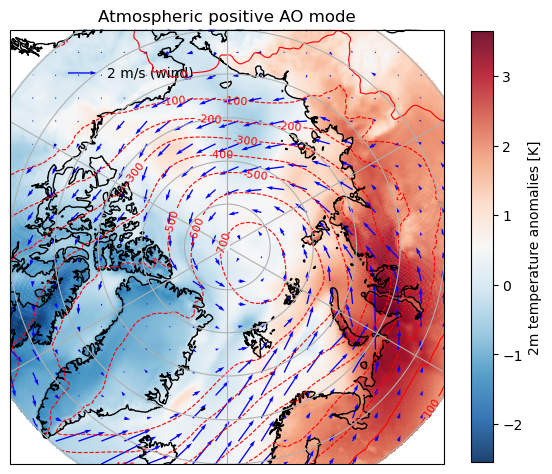

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(projection['t2m']).max()
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    projection.longitude, 
    projection.latitude, 
    projection['t2m'], 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu_r',
    alpha=.9
)
qvr = ax.quiver(
    longitude_mg, 
    latitude_mg, 
    projection['u10_plot'].values, 
    projection['v10_plot'].values, 
    transform=ccrs.PlateCarree(),
    regrid_shape=20,
    scale=30,
    color='blue'
)
ax.quiverkey(qvr, 0.2, 0.9, 2, '2 m/s (wind)', labelpos='E')

cntr = ax.contour(
    projection.longitude, 
    projection.latitude, 
    projection['msl'], 
    transform=ccrs.PlateCarree(), 
    colors='red',
    linewidths=.8,
    levels=8
)
ax.clabel(cntr, inline=True, fontsize=8, fmt='%1.0f')
ax.set_title(f'Atmospheric positive AO mode')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='2m temperature anomalies [K]')
plt.show()


##### Ocean climate

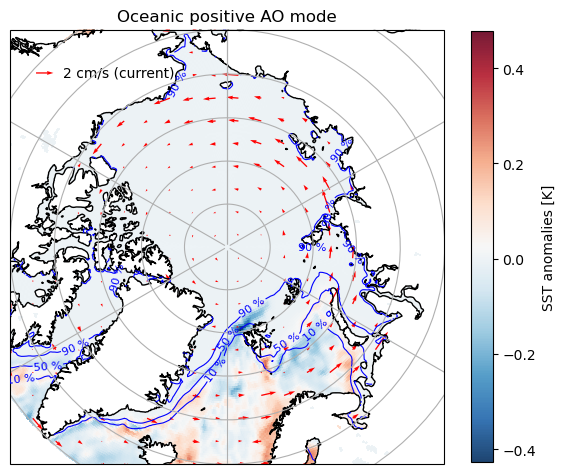

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(projection['sst']).max()
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    projection.longitude, 
    projection.latitude, 
    projection['sst'], 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu_r',
    alpha=.9
)
qvr = ax.quiver(
    longitude_mg, 
    latitude_mg, 
    projection['U_plot'].values, 
    projection['V_plot'].values, 
    transform=ccrs.PlateCarree(),
    regrid_shape=20,
    scale=0.5,
    color='red'
)
ax.quiverkey(qvr, 0.1, 0.9, 0.02, '2 cm/s (current)', labelpos='E')

cntr = ax.contour(
    ds_winter_climatology.longitude, 
    ds_winter_climatology.latitude, 
    ds_winter_climatology['SIC'] * 100, 
    transform=ccrs.PlateCarree(), 
    colors='blue',
    linewidths=.8,
    levels=[10, 50, 90]
)
ax.clabel(cntr, inline=True, fontsize=8, fmt='%1.0f %%')


ax.set_title(f'Oceanic positive AO mode')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='SST anomalies [K]')
plt.show()


##### Ice

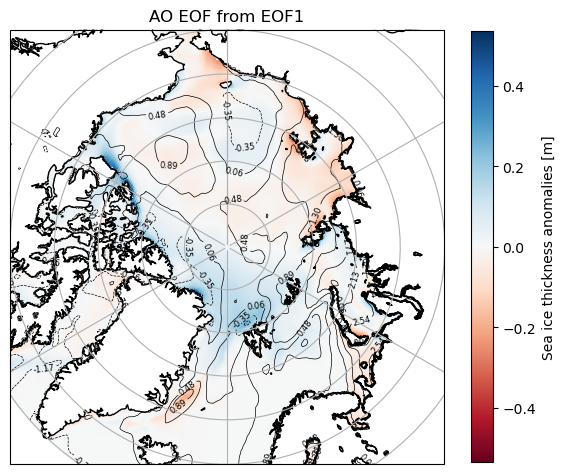

In [36]:

fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(projection['SIT']).max()
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    projection.longitude, 
    projection.latitude, 
    projection['SIT'] * sea_mask, 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu',
    vmin=-max_val,
    vmax=max_val,
)

ctrs = ax.contour(
    projection.longitude, 
    projection.latitude, 
    projection['t2m'] * sea_mask, 
    transform=ccrs.PlateCarree(), 
    levels=np.linspace( (projection['t2m'] * sea_mask).min(),  (projection['t2m'] * sea_mask).max(), 15),
    colors='k',
    linewidths=0.5
)
ax.clabel(ctrs, inline=True, fontsize=6, fmt='%1.2f')

ax.set_title(f'AO EOF from EOF1')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='Sea ice thickness anomalies [m]')
plt.show()


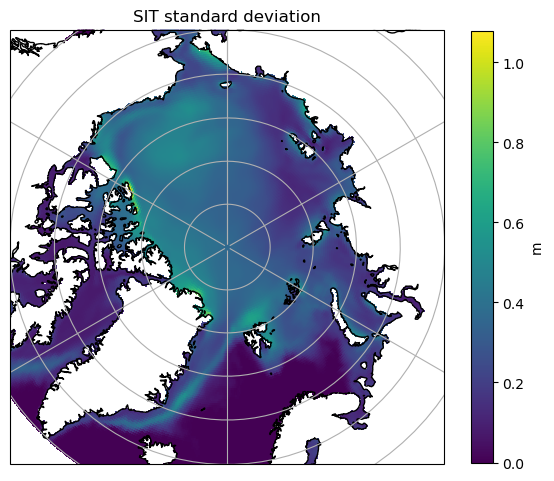

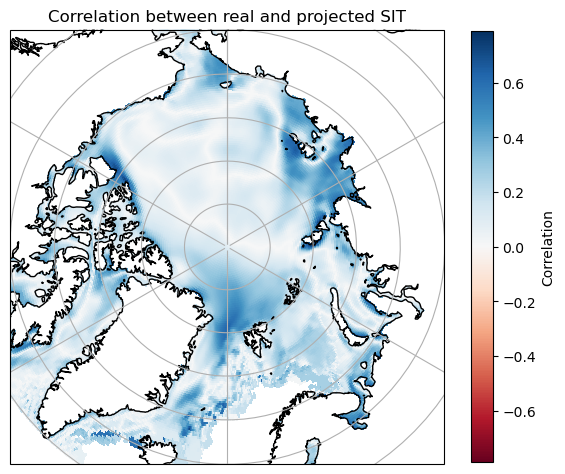

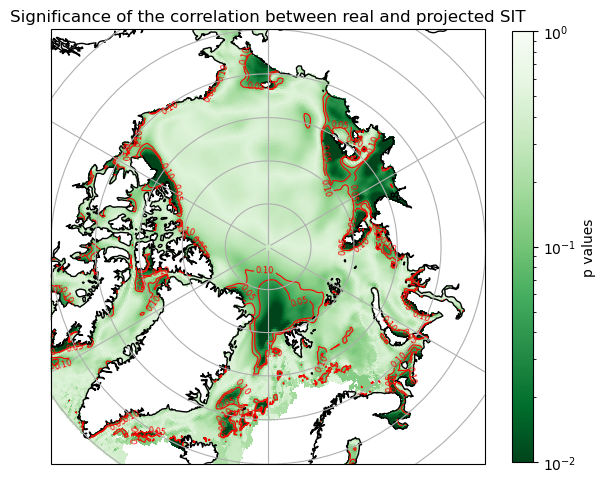

In [94]:
SIT_std = ds_winter_anomalies_detrended['SIT'].std('time')

real_SIT = ds_winter['SIT'] # (time, latitude, longitude)
projected_SIT = projection['SIT'] * AO_time_serie_from_PC1 # (time, latitude, longitude)
corr = (real_SIT * projected_SIT).sum('time') / (real_SIT.std('time') * projected_SIT.std('time')) / len(real_SIT.time)

t_test = corr * np.sqrt(len(real_SIT.time) - 2) / np.sqrt(1 - corr**2)

# Compute p-values from t-test
p_values = 1 - scipy.stats.t.cdf(np.abs(t_test), df=len(real_SIT.time) - 2)

fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(corr).max()
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    corr.longitude, 
    corr.latitude, 
    real_SIT.std('time'), 
    transform=ccrs.PlateCarree(), 
    cmap='viridis'
)
ax.set_title(f'SIT standard deviation')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='m')


fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(corr).max()
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    corr.longitude, 
    corr.latitude, 
    corr, 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu',
    vmin=-max_val,
    vmax=max_val,
)
ax.set_title(f'Correlation between real and projected SIT')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='Correlation')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(corr).max()
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    corr.longitude, 
    corr.latitude, 
    p_values, 
    transform=ccrs.PlateCarree(), 
    cmap='Greens_r',
    norm=colors.LogNorm(vmin=1e-2, vmax=1),
)
cntr = ax.contour(
    corr.longitude, 
    corr.latitude, 
    p_values, 
    transform=ccrs.PlateCarree(), 
    levels=[0.05, 0.1],
    colors='red',
    linewidths=0.8
)
ax.clabel(cntr, inline=True, fontsize=6, fmt='%1.2f')

ax.set_title(f'Significance of the correlation between real and projected SIT')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='p values')
plt.show()


## Summer

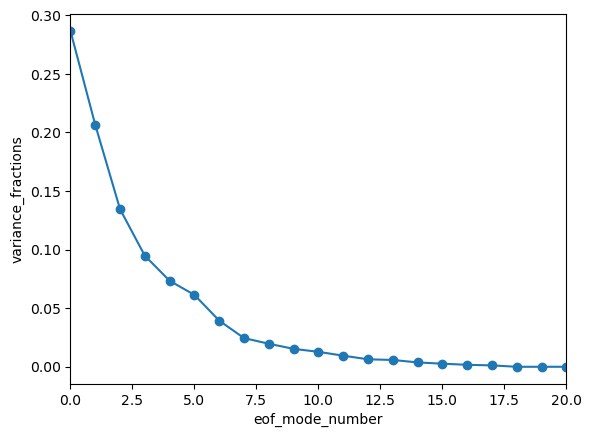

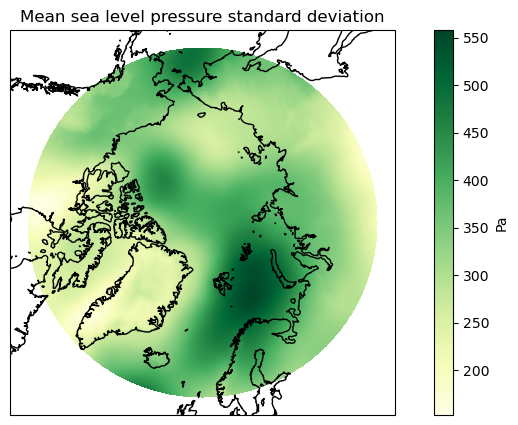

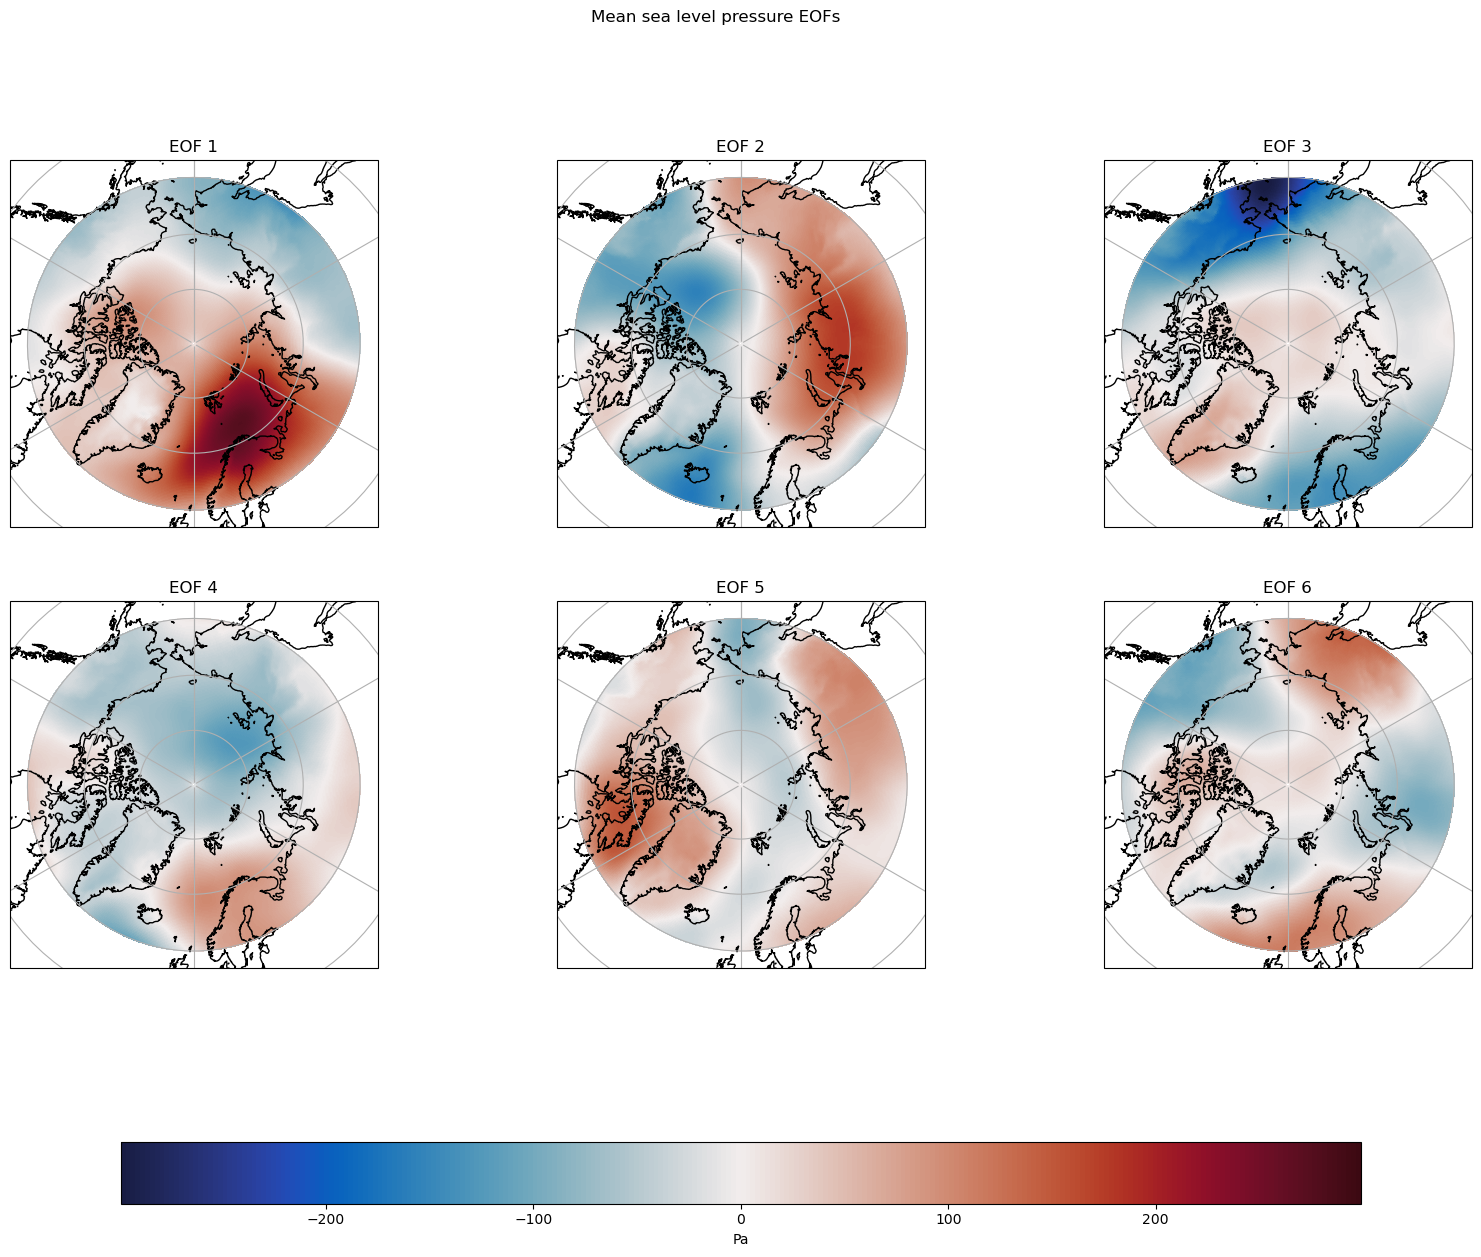

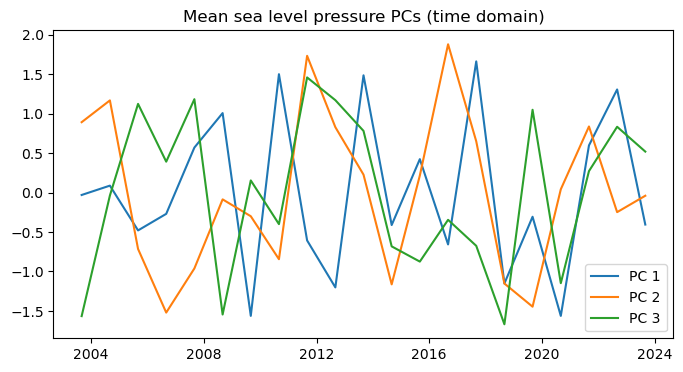

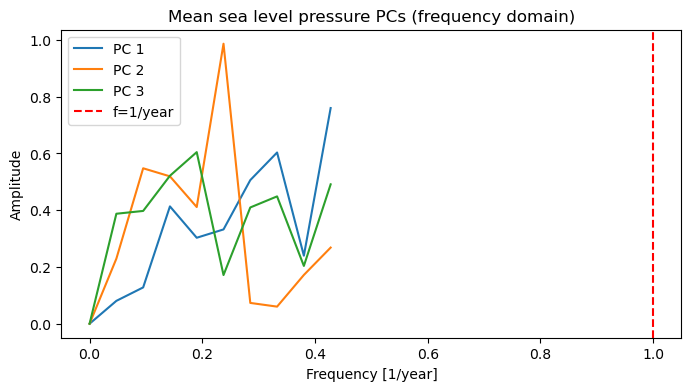

In [20]:
# Computing EOFs
da = ds_summer_anomalies_detrended['msl']
summer_msl_eof_solver = utils_variability.fit_eofs(da)
utils_variability.fast_eof_analysis(summer_msl_eof_solver, da)

Correlation between measured and predicted AO: -0.8793839828396002


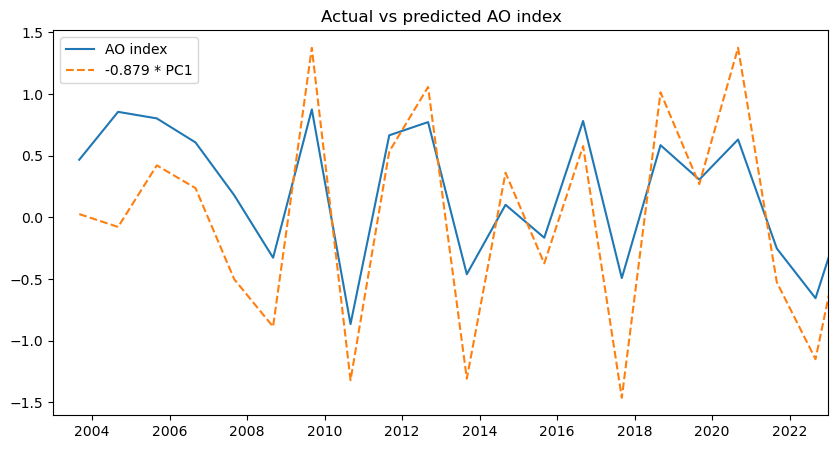

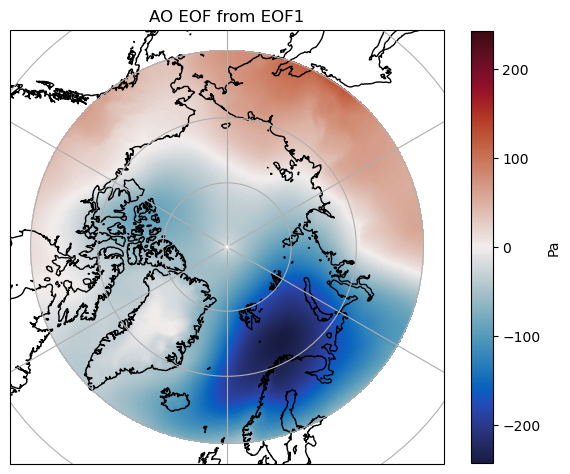

In [21]:
measured_AO = ds_summer_climate_index['AO']
pc1 = summer_msl_eof_solver.pcs(1)[:,0]

corr = np.corrcoef(measured_AO, pc1)[0,1]
print(f'Correlation between measured and predicted AO: {corr}')

AO_time_serie_from_PC1 = pc1 * corr
AO_EOF_from_EOF1 = summer_msl_eof_solver.eofs(eofscaling=2)[0] * corr


plt.figure(figsize=(10, 5))
plt.plot(ds_summer_climate_index.time,measured_AO, label='AO index')
plt.plot(summer_msl_eof_solver.pcs(1).time, AO_time_serie_from_PC1, label=f'{corr:.3f} * PC1', linestyle='--')
plt.legend()
plt.title('Actual vs predicted AO index')
plt.xlim(pd.DatetimeIndex(['2003-01-01', '2023-01-01']))
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(AO_EOF_from_EOF1).max()
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    AO_EOF_from_EOF1.longitude, 
    AO_EOF_from_EOF1.latitude, 
    AO_EOF_from_EOF1, 
    transform=ccrs.PlateCarree(), 
    cmap=cmo.balance,
    norm=colors.Normalize(vmin=-max_val, vmax=max_val),
)
ax.set_title(f'AO EOF from EOF1')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label=da.units)
plt.show()

In [22]:
projection = (ds_summer_anomalies_detrended * AO_time_serie_from_PC1).mean('time')
projection

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 1440)
Coordinates:
    depth      float32 0.5058
  * latitude   (latitude) float32 60.0 60.25 60.5 60.75 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    mode       int64 0
Data variables:
    T          (latitude, longitude) float64 -0.07842 -0.07429 ... -0.006212
    sst        (latitude, longitude) float64 -0.07469 -0.06245 ... 3.778e-05
    t2m        (latitude, longitude) float64 -0.1216 -0.113 ... 0.04597 0.04597
    msl        (latitude, longitude) float64 98.57 98.13 97.67 ... -202.2 -202.2
    sd         (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SIT        (latitude, longitude) float64 0.0 0.0 0.0 ... -0.00165 -0.00165
    u10        (latitude, longitude) float64 -0.0758 -0.07256 ... -0.02537
    v10        (latitude, longitude) float64 -0.1789 -0.1852 ... 0.01589 0.01589

In [23]:
wind_ampl = np.sqrt(projection['u10']**2 + projection['v10']**2)
u_norm = projection['u10']
v_norm = projection['v10'] / np.cos(np.deg2rad(projection.latitude))

u_norm = u_norm / np.sqrt(u_norm**2 + v_norm**2)
v_norm = v_norm / np.sqrt(u_norm**2 + v_norm**2)

projection['u10_plot'] = u_norm * wind_ampl
projection['v10_plot'] = v_norm * wind_ampl

longitude_mg ,latitude_mg = np.meshgrid(projection.longitude, projection.latitude)

sea_mask = ~ projection['sst'].isnull()

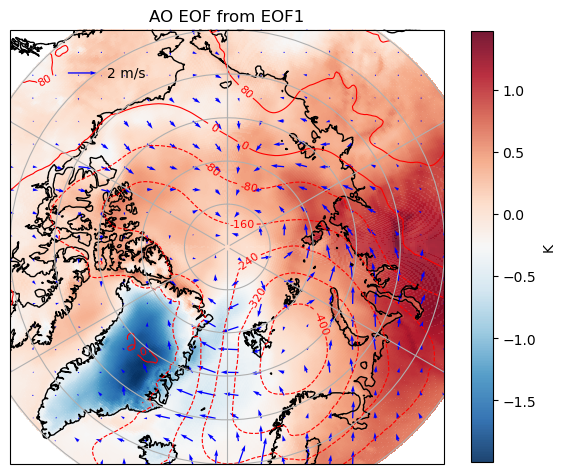

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(projection['t2m']).max()
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    projection.longitude, 
    projection.latitude, 
    projection['t2m'], 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu_r',
    alpha=.9
)
qvr = ax.quiver(
    longitude_mg, 
    latitude_mg, 
    projection['v10_plot'].values, 
    projection['u10_plot'].values, 
    transform=ccrs.PlateCarree(),
    regrid_shape=20,
    scale=30,
    color='blue'
)
ax.quiverkey(qvr, 0.2, 0.9, 2, '2 m/s', labelpos='E')

cntr = ax.contour(
    projection.longitude, 
    projection.latitude, 
    projection['msl'], 
    transform=ccrs.PlateCarree(), 
    colors='red',
    linewidths=.8,
    levels=8
)
ax.clabel(cntr, inline=True, fontsize=8, fmt='%1.0f')
ax.set_title(f'AO EOF from EOF1')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='K')
plt.show()


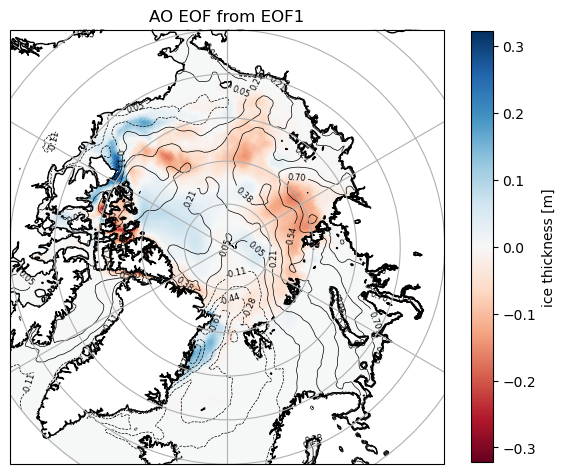

In [25]:

fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(projection['SIT']).max()
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    projection.longitude, 
    projection.latitude, 
    projection['SIT'] * sea_mask, 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu',
    vmin=-max_val,
    vmax=max_val,
)

ctrs = ax.contour(
    projection.longitude, 
    projection.latitude, 
    projection['t2m'] * sea_mask, 
    transform=ccrs.PlateCarree(), 
    levels=np.linspace( (projection['t2m'] * sea_mask).min(),  (projection['t2m'] * sea_mask).max(), 15),
    colors='k',
    linewidths=0.5
)
ax.clabel(ctrs, inline=True, fontsize=6, fmt='%1.2f')

ax.set_title(f'AO EOF from EOF1')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='ice thickness [m]')
plt.show()
